In [1]:
import os
import osmnx as ox
# from pyspark import SparkContext,SparkConf
# from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
# from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
# from pyspark import SparkConf
import pandas as pd
# import pickle
# from tqdm import tqdm

/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

22/10/18 20:34:54 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/10/18 20:34:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/18 20:34:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/18 20:34:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
f = os.path.join('/home/jptalusan/mta_stationing_problem/data/processed/apc_weather_gtfs.parquet')
apcdata = spark.read.load(f)
print(apcdata.columns)
get_columns = ['stop_id_original', 'map_latitude', 'map_longitude']
get_str = ", ".join([c for c in get_columns])
apcdata.createOrReplaceTempView("apc")
# # filter subset
query = f"""
       SELECT {get_str}
       FROM apc
       """
print(query)
apcdata = spark.sql(query)
apcdata = apcdata.dropDuplicates(['stop_id_original'])
apcdf = apcdata.toPandas()

['gtfs_date', 'dayofweek', 'hour', 'gtfs_route_id', 'gtfs_direction_id', 'stop_id', 'transit_date', 'trip_id', 'day', 'overload_id', 'vehicle_id', 'block_abbr', 'activation_date', 'activation_date_str', 'arrival_time', 'arrival_time_str', 'block_stop_order', 'deactivation_date', 'deactivation_date_str', 'departure_time', 'departure_time_str', 'load', 'load_factor', 'map_latitude', 'map_longitude', 'offs', 'ons', 'pattern_num', 'route_direction_name', 'route_id', 'scheduled_time', 'scheduled_time_str', 'source_pattern_id', 'stop_id_list', 'stop_id_original', 'stop_name', 'stop_sequence', 'stop_sequence_list', 'transit_date_str', 'update_date', 'vehicle_capacity', 'zero_load_at_trip_end', 'count', 'darksky_temperature', 'darksky_humidity', 'darksky_nearest_storm_distance', 'darksky_precipitation_intensity', 'darksky_precipitation_probability', 'darksky_pressure', 'darksky_wind_gust', 'darksky_wind_speed', 'weatherbit_rh', 'weatherbit_wind_spd', 'weatherbit_app_temp', 'weatherbit_temp', '

In [4]:
apcdf.head()

,stop_id_original,map_latitude,map_longitude
0,8A9ANM,36.169933,-86.789091
1,BOYBUENN,36.227897,-86.827407
2,HERDECWN,36.153648,-86.753553
3,LEBBONWM,36.189506,-86.627722
4,LEBOMOEN,36.154402,-86.739793


In [5]:
fp = os.path.join('data', 'davidson_graph.graphml')
G = ox.load_graphml(fp)

In [7]:
apcdf.query("stop_id_original == 'BAPSEMNN'")

,stop_id_original,map_latitude,map_longitude
9,BAPSEMNN,36.200568,-86.786623


In [13]:
fp = 'results/stops_node_matching.pkl'
df = pd.read_pickle(fp)
df.query("stop_id_original == 'MCC5_1'")

,stop_sequence,stop_id_original,stop_name,map_latitude,map_longitude,nearest_node,nearest_edge
1063,1,MCC5_1,CENTRAL 5TH AVE - BAY 1,36.167091,-86.781923,1443059058,"(202338737, 202338859, 0)"


In [14]:
current_node = 1443059058
next_node = 202443952
try:
    r = ox.shortest_path(G, current_node, next_node, weight='length')
    cols = ['osmid', 'length', 'travel_time']
    attrs = ox.utils_graph.get_route_edge_attributes(G, r)
    tt = pd.DataFrame(attrs)[cols]['travel_time'].sum()
    dd = pd.DataFrame(attrs)[cols]['length'].sum()
except:
    tt = -1
    dd = -1

In [15]:
tt, dd

(334.09999999999997, 5203.804)

In [36]:
fp = 'results/pair_tt_dd_stops.pkl'
df = pd.read_pickle(fp)
df.query("current_stop == 'MCC5_1' and next_stop == 'BAPSEMNN'")

,current_node,next_node,travel_time_s,distance_m,current_stop,next_stop


In [37]:
df.query("current_stop == 'BAPSEMNN' and next_stop == 'MCC5_1'")

,current_node,next_node,travel_time_s,distance_m,current_stop,next_stop
1148693,202443952,1443059058,338.9,5212.0,BAPSEMNN,MCC5_1


In [38]:
df['key_pair'] = list(zip(df.current_stop, df.next_stop))
df = df.set_index('key_pair')

In [39]:
stops_tt_dd_dict = df.drop(['current_node', 'next_node', 'current_stop', 'next_stop'], axis=1).to_dict('index')

In [40]:
stops_tt_dd_dict[('BAPSEMNN', 'MCC5_1')]

{'travel_time_s': 338.8999999999999, 'distance_m': 5212.0}

In [31]:
len(list(stops_tt_dd_dict.keys()))

3284820

In [41]:
import pickle 

with open('results/stops_tt_dd_dict.pkl', 'wb') as handle:
    pickle.dump(stops_tt_dd_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
# stops_tt_dd = {}

# for k, v in df.iterrows():
#     cn = v['current_node']
#     nn = v['next_node']
#     tt = v['travel_time_s']
#     dd = v['distance_m']
#     cs = v['current_stop']
#     ns = v['next_stop']
    
#     stops_tt_dd[cs] = {'next_stop': ns, 
#                        'travel_time_s': tt,
#                        'distance_m': dd}


KeyboardInterrupt: 

In [28]:
travel_time_path = 'results/sampled_travel_times.pkl'
df = pd.read_pickle(travel_time_path)
#         tdf = self.sampled_travel_time[(self.sampled_travel_time['route_id_direction'] == route_id_dir) & \
#                                        (self.sampled_travel_time['block_abbr'] == block_abbr) & \
#                                        (self.sampled_travel_time['stop_sequence'] == current_stop_number + 1) & \
#                                        (self.sampled_travel_time['stop_id_original'] == stop_id_original) & \
#                                        (self.sampled_travel_time['IsWeekend'] == IsWeekend)]

In [29]:
df['key_pair'] = list(zip(df.route_id_direction, df.block_abbr, df.stop_sequence, df.stop_id_original, df.time, df.IsWeekend))
df = df.set_index('key_pair')
sampled_travel_time_dict = df.drop(['time_to_next_stop', 'route_id_direction', 'block_abbr', 'stop_sequence', 'stop_id_original', 'time', 'IsWeekend'], axis=1).to_dict('index')

In [34]:
import pickle 

with open('results/sampled_travel_times_dict.pkl', 'wb') as handle:
    pickle.dump(sampled_travel_time_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
list(sampled_travel_time_dict.keys())[0]

('14_FROM DOWNTOWN', 1400, 1, '1SJAMNM', datetime.time(7, 18, 13), 0)

In [31]:
import datetime as dt

dt.datetime.strptime("7:18:13", "%H:%M:%S").time() == dt.time(7, 18, 13)

True

In [32]:
dt.time(7, 18, 13)

datetime.time(7, 18, 13)

In [35]:
rid = '14_FROM DOWNTOWN'
bid = 1400
ssq = 1
sid = 'MCC4_20'
tme = dt.datetime.strptime("7:18:13", "%H:%M:%S").time() 
wkd = 0
key = (rid, bid, ssq, sid, tme, wkd)
sampled_travel_time_dict[key]

{'sampled_travel_time': 143.0}

In [ ]:
('14_FROM DOWNTOWN', 1400, 1, 'MCC4_20', datetime.time(7, 18, 13), 0)

In [2]:
import pandas as pd
fp = 'results/stops_node_matching.pkl'
df = pd.read_pickle(fp)
df

,stop_sequence,stop_id_original,stop_name,map_latitude,map_longitude,nearest_node,nearest_edge
0,24,12ADEMNN,12TH AVE S & DEMONBREUN ST NB,36.154509,-86.786056,202342839,"(202342839, 202284281, 0)"
1,22,12ADIVNN,12TH AVE S & DIVISION ST NB,36.150417,-86.784338,202189411,"(202300128, 202315471, 0)"
2,24,16SFATSN,16TH ST & FATHERLAND ST SB,36.173512,-86.742468,202301462,"(202301462, 202324500, 0)"
3,21,19SFATNN,S 19TH ST & FATHERLAND ST NB,36.172884,-86.737058,202301467,"(202301467, 202310609, 0)"
4,47,1SOLDSM,N 1ST ST & OLDHAM ST SB,36.172806,-86.774050,202374591,"(202374591, 7251999645, 0)"
...,...,...,...,...,...,...,...
2095,22,WHIFRANN,WHITES CREEK PIKE & FRANCIS ST NB,36.213771,-86.799842,202301967,"(202301963, 202301967, 0)"
2096,3,WHIKENSN,WHITE BRIDGE PIKE & KENDALL SB,36.139637,-86.857509,202258742,"(202258742, 202259611, 0)"
2097,10,WHIPOSSN,WHITE BRIDGE PIKE & POST RD SB,36.128043,-86.852227,202246405,"(202290049, 202246405, 0)"
2098,7,WHIVINSM,WHITE BRIDGE PIKE & VINE RIDGE DR S,36.133673,-86.858250,2473512360,"(202290062, 2473512360, 0)"


In [5]:
df[df['stop_id_original'].str.contains('WESWILEN')]

,stop_sequence,stop_id_original,stop_name,map_latitude,map_longitude,nearest_node,nearest_edge
1570,14,WESWILEN,WEST END & WILSON BLVD,36.131239,-86.834654,202384294,"(202242765, 202384294, 0)"


## DBSCAN Clustering

[[  -1   75]
 [   0 1786]
 [   1   52]
 [   2   18]
 [   3  122]
 [   4   13]
 [   5   16]
 [   6    8]
 [   7   10]]
[[ -1 579]
 [  0 655]
 [  1  83]
 [  2  69]
 [  3  23]
 [  4 102]
 [  5  22]
 [  6  22]
 [  7  49]
 [  8  12]
 [  9  14]
 [ 10  13]
 [ 11  21]
 [ 12  24]
 [ 13  10]
 [ 14  13]
 [ 15  16]
 [ 16  18]
 [ 17  10]
 [ 18  10]
 [ 19  21]]
21


/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

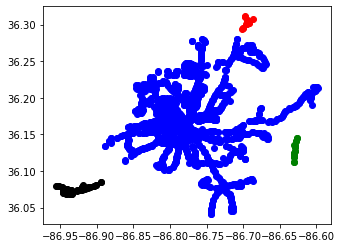

In [86]:
from sklearn.cluster import DBSCAN
import numpy as np

import pandas as pd
fp = 'results/stops_node_matching.pkl'
df = pd.read_pickle(fp)
df

db = DBSCAN(eps=0.00019, min_samples=10, metric='haversine')
res = db.fit(np.radians(df[['map_latitude', 'map_longitude']]))
labels = res.labels_
num_clusters = len(set(labels))

unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)
df['label'] = labels

import geopandas as gpd
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.map_longitude, df.map_latitude))
# gdf.query("label == 0").plot(color='red')
df = gdf.query("label == 0")

db = DBSCAN(eps=0.00008, min_samples=10, metric='haversine')
res = db.fit(np.radians(df[['map_latitude', 'map_longitude']]))
labels = res.labels_
num_clusters = len(set(labels))

unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)
df['label'] = labels
print(num_clusters)
ax = gdf.query("label == 4").plot(color='red')
gdf.query("label == 0").plot(color='blue', ax=ax)
gdf.query("label == 2").plot(color='green', ax=ax)
gdf.query("label == 1").plot(color='black', ax=ax)

### Break Davidson into grids

5
5


<AxesSubplot:>

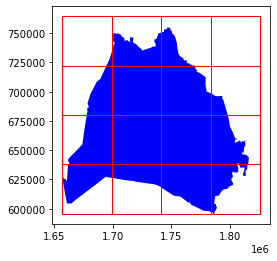

In [91]:
from shapely.geometry import Polygon

fp = os.path.join('data', 'shapefiles', "tncounty")
gdf_county = gpd.read_file(fp)
gdf_dav = gdf_county[gdf_county["NAME"] == "Davidson"]
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds
length = 5280 * 8
wide = 5280 * 8

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(cols))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
fp = os.path.join('data', 'shapefiles', 'grid_shapes.shp')
grid.to_file(fp)
grid.plot(ax = gdf_dav.plot(color='blue'), color='none', edgecolor='red')